In [7]:
import ehrapy as ep
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import graphviz

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)


## Load data with drugcats added

In [2]:
adata = ep.io.read_csv("./adata_pneumonia_drugcats_added.csv", sep="\t")
adata


2023-09-01 11:33:16,256 - root INFO - Added all columns to `obs`.
2023-09-01 11:33:16,380 - root INFO - Transformed passed dataframe into an AnnData object with n_obs x n_vars = `277` x `1291`.


AnnData object with n_obs × n_vars = 277 × 1291
    uns: 'numerical_columns', 'non_numerical_columns'
    layers: 'original'

In [3]:
adata_surviving = adata[adata.to_df()["Death"] == 0]
adata_dead = adata[adata.to_df()["Death"] == 1]

## Input Phillips graph

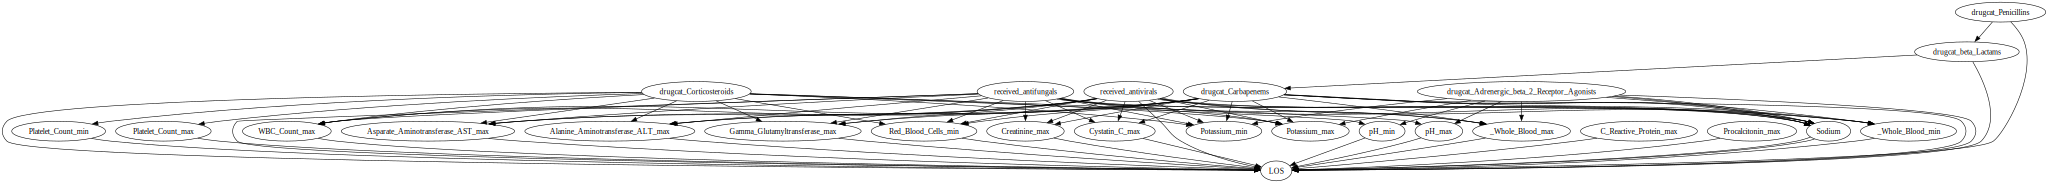

In [4]:
causal_graph = """digraph {

drugcat_Corticosteroids -> Asparate_Aminotransferase_AST_max;
drugcat_Corticosteroids -> Alanine_Aminotransferase_ALT_max;
drugcat_Corticosteroids -> Gamma_Glutamyltransferase_max;
drugcat_Corticosteroids -> Platelet_Count_min;
drugcat_Corticosteroids -> Platelet_Count_max;
drugcat_Corticosteroids -> Potassium_min;
drugcat_Corticosteroids -> Potassium_max;
drugcat_Corticosteroids -> pH_min;
drugcat_Corticosteroids -> pH_max;
drugcat_Corticosteroids -> Red_Blood_Cells_min;
drugcat_Corticosteroids -> WBC_Count_max;

received_antifungals -> Asparate_Aminotransferase_AST_max;
received_antifungals -> Alanine_Aminotransferase_ALT_max;
received_antifungals -> Gamma_Glutamyltransferase_max;
received_antifungals -> Creatinine_max;
received_antifungals -> Cystatin_C_max;
received_antifungals -> Red_Blood_Cells_min;
received_antifungals -> WBC_Count_max;
received_antifungals -> Sodium,_Whole_Blood_min;
received_antifungals -> Sodium,_Whole_Blood_max;
received_antifungals -> Potassium_min;
received_antifungals -> Potassium_max;

received_antivirals -> Asparate_Aminotransferase_AST_max;
received_antivirals -> Alanine_Aminotransferase_ALT_max;
received_antivirals -> Gamma_Glutamyltransferase_max;
received_antivirals -> Creatinine_max;
received_antivirals -> Cystatin_C_max;
received_antivirals -> Red_Blood_Cells_min;
received_antivirals -> WBC_Count_max;
received_antivirals -> Sodium,_Whole_Blood_min;
received_antivirals -> Sodium,_Whole_Blood_max;
received_antivirals -> Potassium_min;
received_antivirals -> Potassium_max;

drugcat_Carbapenems -> Asparate_Aminotransferase_AST_max;
drugcat_Carbapenems -> Alanine_Aminotransferase_ALT_max;
drugcat_Carbapenems -> Gamma_Glutamyltransferase_max;
drugcat_Carbapenems -> Creatinine_max;
drugcat_Carbapenems -> Cystatin_C_max;
drugcat_Carbapenems -> Red_Blood_Cells_min;
drugcat_Carbapenems -> WBC_Count_max;
drugcat_Carbapenems -> Sodium,_Whole_Blood_min;
drugcat_Carbapenems -> Sodium,_Whole_Blood_max;
drugcat_Carbapenems -> Potassium_min;
drugcat_Carbapenems -> Potassium_max;
    
drugcat_Penicillins -> drugcat_beta_Lactams;
drugcat_beta_Lactams -> drugcat_Carbapenems;

drugcat_Adrenergic_beta_2_Receptor_Agonists -> Sodium,_Whole_Blood_min;
drugcat_Adrenergic_beta_2_Receptor_Agonists -> Sodium,_Whole_Blood_max;
drugcat_Adrenergic_beta_2_Receptor_Agonists -> Potassium_min;
drugcat_Adrenergic_beta_2_Receptor_Agonists -> Potassium_max;
drugcat_Adrenergic_beta_2_Receptor_Agonists -> pH_min;
drugcat_Adrenergic_beta_2_Receptor_Agonists -> pH_max;

Asparate_Aminotransferase_AST_max -> LOS;
Alanine_Aminotransferase_ALT_max -> LOS;
Gamma_Glutamyltransferase_max -> LOS;
Creatinine_max -> LOS;
Cystatin_C_max -> LOS;
C_Reactive_Protein_max -> LOS;
Procalcitonin_max -> LOS;
Platelet_Count_min -> LOS;
Platelet_Count_max -> LOS;
Red_Blood_Cells_min -> LOS;
WBC_Count_max -> LOS;
Sodium,_Whole_Blood_min -> LOS;
Sodium,_Whole_Blood_max -> LOS;
pH_min -> LOS;
pH_max -> LOS;
drugcat_Adrenergic_beta_2_Receptor_Agonists -> LOS;
drugcat_Corticosteroids -> LOS;
drugcat_Carbapenems -> LOS;
drugcat_Penicillins -> LOS;
drugcat_beta_Lactams -> LOS;
received_antifungals -> LOS;
received_antivirals -> LOS;


}"""

g = graphviz.Source(causal_graph)
display(g)

In [12]:
import logging

logger = logging.getLogger()
logger.disabled = True

cols = [
    "drugcat_Corticosteroids",
    "received_antifungals",
    "received_antivirals",
    "drugcat_Carbapenems",
    "drugcat_Penicillins",
    "drugcat_beta_Lactams",
    "drugcat_Adrenergic_beta_2_Receptor_Agonists",
    "Asparate_Aminotransferase_AST_max",
    "Alanine_Aminotransferase_ALT_max",
    "Gamma_Glutamyltransferase_max",
    "Creatinine_max",
    "Cystatin_C_max",
    "C_Reactive_Protein_max",
    "Procalcitonin_max",
    "Platelet_Count_min",
    "Platelet_Count_max",
    "Red_Blood_Cells_min",
    "WBC_Count_max",
    "Sodium,_Whole_Blood_min",
    "Sodium,_Whole_Blood_max",
    "pH_min",
    "pH_max",
]

for treatment in cols:

    try:

        e = ep.tl.causal_inference(
            adata=adata_dead, 
            graph=causal_graph,
            treatment=treatment, 
            outcome="LOS", 
            estimation_method="backdoor.linear_regression",
            refute_methods = [
                "placebo_treatment_refuter",
                "random_common_cause",
                "data_subset_refuter",
                # "add_unobserved_common_cause"
            ],
            print_causal_estimate=False,
            print_summary=True,
            show_graph=False,
            show_refute_plots="colormesh",
            return_as="estimate",
            # estimate_kwargs={"glm_family": statsmodels.api.families.Binomial()},
            identify_kwargs={"proceed_when_unidentifiable": True},
            attempts=0,
        )
        print(treatment, np.round(e.value, 3))
    
    except:
        pass
    
    
logger.disabled = False

Causal inference results for treatment variable 'drugcat_Corticosteroids' and outcome variable 'LOS':
└- Increasing the treatment variable(s) [drugcat_Corticosteroids] from 0 to 1 causes an increase of -4.372410605133364 in the expected value of the outcome [['LOS']], over the data distribution/population represented by the dataset.

Refutation results
├-Refute: Use a Placebo Treatment
|    ├- Estimated effect: -4.37
|    ├- New effect: 0.000
|    ├- p-value: nan
|    └- Test significance: -4.37
├-Refute: Add a random common cause
|    ├- Estimated effect: -4.37
|    ├- New effect: -4.503
|    ├- p-value: 0.442
|    └- Test significance: -4.37
└-Refute: Use a subset of data
     ├- Estimated effect: -4.37
     ├- New effect: -4.474
     ├- p-value: 0.490
     └- Test significance: -4.37

drugcat_Corticosteroids -4.372
Causal inference results for treatment variable 'received_antifungals' and outcome variable 'LOS':
└- Increasing the treatment variable(s) [received_antifungals] from 0 t

## Make figure

Text(0, 0.5, '')

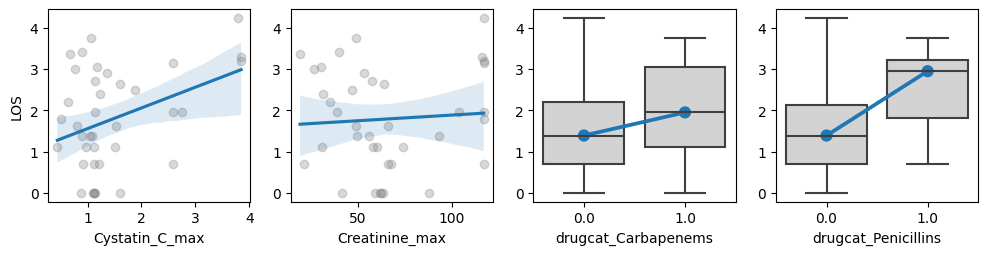

In [11]:
data_for_plot = adata_dead.to_df()[[
    "LOS",
    "drugcat_Carbapenems",
    "drugcat_Penicillins",
    "Cystatin_C_max",
    "Creatinine_max",
]]

data_for_plot["LOS"] = np.log1p(data_for_plot["LOS"])

fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(12, 2.5))

sns.regplot(data=data_for_plot, x="Cystatin_C_max", y="LOS", scatter_kws={"alpha":0.3, "color": "grey"}, ax=axs[0])
axs[0].set_ylabel("LOS")

sns.regplot(data=data_for_plot, x="Creatinine_max", y="LOS", scatter_kws={"alpha":0.3, "color": "grey"}, ax=axs[1])
axs[1].set_ylabel("")

sns.boxplot(data=data_for_plot, x="drugcat_Carbapenems", y="LOS", boxprops={"facecolor": "lightgrey"}, ax=axs[2])
sns.pointplot(data=data_for_plot.groupby('drugcat_Carbapenems', as_index=False).median(), x='drugcat_Carbapenems', y='LOS', ax=axs[2])
axs[2].set_ylabel("")

sns.boxplot(data=data_for_plot, x="drugcat_Penicillins", y="LOS", boxprops={"facecolor": "lightgrey"}, ax=axs[3])
sns.pointplot(data=data_for_plot.groupby('drugcat_Penicillins', as_index=False).median(), x='drugcat_Penicillins', y='LOS', ax=axs[3])
axs[3].set_ylabel("")


In [ ]:
data_for_plot["LOS"].mean()

2.1355665